# Setup

In [1]:
import os
if not os.path.exists('pytorch_stylegan_encoder'):
    # These are the basic instructions for getting started with the StyleGAN implementation.
    !git clone https://github.com/jacobhallberg/pytorch_stylegan_encoder.git
    %cd pytorch_stylegan_encoder

    # I looked up git submodule update:
    #   A git submodule is a record within a host git repository that points to a 
    #   specific commit in another external repository.

    # And from further digging:
    #   git submodule update --init --recursive will register direct dependent submodules 
    #   and clone them down, then go into next depth, register submodules and clone them recursively.

    # Basically, this is recursively loading all the sub-repositories within the jacobhallberg/pytorch_stylegan_encoder
    # repo. An alternate approach is to simply clone the repo with the '--recursive' flag.
    !git submodule update --init --recursive

    # Within the releases from the repo, they have a trained_models.zip file and we are simply getting it with the 
    # wget command. 
    !wget -q https://github.com/jacobhallberg/pytorch_stylegan_encoder/releases/download/v1.0/trained_models.zip
    !unzip -q trained_models.zip
    !rm trained_models.zip
    
    # Simply installs and upgrades torch_snippets to the latest available version.
    !pip install -qU torch_snippets

    # Moves the pretrained model file to the proper file directory.
    !mv trained_models/stylegan_ffhq.pth InterFaceGAN/models/pretrain
else:
    %cd pytorch_stylegan_encoder
    
from torch_snippets import *

Cloning into 'pytorch_stylegan_encoder'...
remote: Enumerating objects: 358, done.
remote: Total 358 (delta 0), reused 0 (delta 0), pack-reused 358
Receiving objects: 100% (358/358), 56.88 MiB | 33.28 MiB/s, done.
Resolving deltas: 100% (185/185), done.
/content/pytorch_stylegan_encoder
Submodule 'InterFaceGAN' (git://github.com/ShenYujun/InterFaceGAN.git) registered for path 'InterFaceGAN'
Cloning into '/content/pytorch_stylegan_encoder/InterFaceGAN'...
Submodule path 'InterFaceGAN': checked out 'b707e942187f464251f855c92f7009b8cf13bf03'
     |████████████████████████████████| 42 kB 724 kB/s 
     |████████████████████████████████| 56 kB 3.7 MB/s 
     |████████████████████████████████| 57 kB 4.4 MB/s 
     |████████████████████████████████| 10.1 MB 40.3 MB/s 
     |████████████████████████████████| 214 kB 51.7 MB/s 
     |████████████████████████████████| 51 kB 6.6 MB/s 


- [More on the git submodule init recursive command](https://stackoverflow.com/questions/24057871/git-submodule-update-init-recursive-vs-git-submodule-foreach-recursive#:~:text=git%20submodule%20update%20--init%20--recursive%20will%20register%20direct,exists%20cyclic%20dependency%2C%20this%20command%20will%20never%20terminate)
- [What is a submodule?](https://www.vogella.com/tutorials/GitSubmodules/article.html#:~:text=Using%20submodules%20in%20Git%20-%20Tutorial%201%20Submodules,with%20submodules.%20...%204%20Links%20and%20Literature.%20)
- [What is wget?](https://www.tutorialspoint.com/unix_commands/wget.htm)
- What is the -U flag?

To answer this question, simply run this in colab or in your cmd:

```cmd
!pip help install > help_install.txt
```
-U basically upgrades all specified packages to their newest available versions. The handling of dependencies depends on the upgrade-strategy you use.

- [What is the mv command?](https://www.geeksforgeeks.org/mv-command-linux-examples/)

# Generating Human Faces from Latent Vector

In [2]:
from InterFaceGAN.models.stylegan_generator import StyleGANGenerator

# Oh, I see so the InterFaceGAN has many different GAN files in there. I suppose the name is
# just for a general case. Or maybe InterFaceGAN is an actual GAN?

# This is for some preprocessing after the synthesis network I believe.
from models.latent_optimizer import PostSynthesisProcessing

# These are the 3 networks that constitute the StyleGAN1 Generator I believe.
# You load these 3 networks with the weights in the "stylegan_ffhq" weights file.
synthesizer = StyleGANGenerator("stylegan_ffhq").model.synthesis
mapper = StyleGANGenerator("stylegan_ffhq").model.mapping
trunc = StyleGANGenerator("stylegan_ffhq").model.truncation

[2021-12-23 01:59:35,738][INFO] Loading pytorch model from `InterFaceGAN/models/pretrain/stylegan_ffhq.pth`.
[2021-12-23 01:59:36,007][INFO] Successfully loaded!
[2021-12-23 01:59:36,017][INFO]   `lod` of the loaded model is 0.0.
[2021-12-23 01:59:46,922][INFO] Loading pytorch model from `InterFaceGAN/models/pretrain/stylegan_ffhq.pth`.
[2021-12-23 01:59:47,146][INFO] Successfully loaded!
[2021-12-23 01:59:47,149][INFO]   `lod` of the loaded model is 0.0.
[2021-12-23 01:59:47,447][INFO] Loading pytorch model from `InterFaceGAN/models/pretrain/stylegan_ffhq.pth`.
[2021-12-23 01:59:47,639][INFO] Successfully loaded!
[2021-12-23 01:59:47,641][INFO]   `lod` of the loaded model is 0.0.


*What is inside PostSynthesisProcessing?*

Let's go check this out in this episode of What's Inside?



```py
class PostSynthesisProcessing(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.min_value = -1
        self.max_value = 1

    def forward(self, synthesized_image):
        synthesized_image = (synthesized_image - self.min_value) * torch.tensor(255).float() / (self.max_value - self.min_value)
        synthesized_image = torch.clamp(synthesized_image + 0.5, min=0, max=255)

        return synthesized_image
```

Interesting. It seems like they use minmax scaling + 0.5? Let's investigate the effects of this postprocessing.



In [3]:
import skimage
from matplotlib import pyplot as plt

img = skimage.data.astronaut()
assert img.max() == 255 and img.min() == 0
img = img / 255.0

# print(img[0] * 255.0)

# Testing it.

min_value = -1
max_value = 1

img = (img - min_value) * 255.0 / (max_value - min_value)
img = np.clip(img + 0.5, a_min=0, a_max=255)

print(img.max(), img.min())

# Interesting. So the 0.5 simply shifts the 0 to 128 so that the range pixel values can take
# are cut in half.

255.0 128.0


In [4]:
post_processing = PostSynthesisProcessing()
post_process = lambda image: post_processing(image).detach().cpu().numpy().astype(np.uint8)[0]

# So this function simply takes in a latent vector of shape (B, 512) where 512 is the z_dim.
# It will run it through the synthesizer and then post process it with minmax scaling + 0.5.
# It will then convert it to numpy and uint8, transpose, and return the image.
def latent2image(latent):
    img = post_process(synthesizer(latent))
    img = img.transpose(1,2,0)
    return img

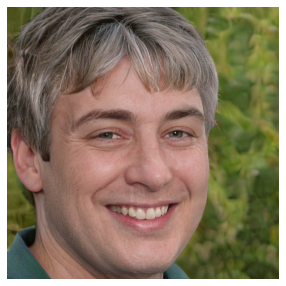

In [5]:
# Latent vector.
rand_latents = torch.randn(1,512).cuda()

# Run through mapper, truncator, and then finally the synthesis network.
show(latent2image(trunc(mapper(rand_latents))), sz=5)

# Transferring Style from One Image to Another

In [6]:
# Get the image.
!wget -q https://www.dropbox.com/s/lpw10qawsc5ipbn/MyImage.JPG -O MyImage.jpg

# This github repo also implements the StyleGAN encoder/generator in PyTorch.
# In my opinion, the Puzer repo is more fine-grained whereas the 
# jacobhallberg repo is more high-level.

# To generate images, we simply need the jacobhallberg repo. For style transfer,
# we use both repos.
!git clone https://github.com/Puzer/stylegan-encoder.git
!mkdir -p stylegan-encoder/raw_images
!mkdir -p stylegan-encoder/aligned_images

# Move the downloaded image into the raw_images folder. 
!mv MyImage.jpg stylegan-encoder/raw_images

Cloning into 'stylegan-encoder'...
remote: Enumerating objects: 105, done.
remote: Total 105 (delta 0), reused 0 (delta 0), pack-reused 105
Receiving objects: 100% (105/105), 10.39 MiB | 6.18 MiB/s, done.
Resolving deltas: 100% (28/28), done.


In [56]:
%ls

# Remember we cloned the Puzer repo within the "pytorch_stylegan_encoder" folder. 
# It sits with all the other folders from the jacobhallberg repo.

assets/          models/            trained_models/
encode_image.py  README.md          train_image_to_latent_model.ipynb
InterFaceGAN/    stylegan-encoder/  utilities/


In [7]:
# Call the align_images.py file. Let's inspect what this file is doing.

# I got an ImportError when calling this python script. It said it couldn't import 'get_files' from keras.utils.
# Simple fix: go into the script and change that import line to: 'from tensorflow.keras.utils import get_file'.
!python stylegan-encoder/align_images.py stylegan-encoder/raw_images/ stylegan-encoder/aligned_images/

# Take the aligned iamge and move it.
!mv stylegan-encoder/aligned_images/* ./MyImage.jpg

64053248/64040097 [==============================] - 1s 0us/step


Inspecting align_images.py ...



```py
import os
import sys
import bz2
from keras.utils import get_file
from ffhq_dataset.face_alignment import image_align
from ffhq_dataset.landmarks_detector import LandmarksDetector

LANDMARKS_MODEL_URL = 'http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2'


def unpack_bz2(src_path):
    data = bz2.BZ2File(src_path).read()
    dst_path = src_path[:-4]
    with open(dst_path, 'wb') as fp:
        fp.write(data)
    return dst_path


if __name__ == "__main__":
    """
    Extracts and aligns all faces from images using DLib and a function from original FFHQ dataset preparation step
    python align_images.py /raw_images /aligned_images
    """

    landmarks_model_path = unpack_bz2(get_file('shape_predictor_68_face_landmarks.dat.bz2',
                                               LANDMARKS_MODEL_URL, cache_subdir='temp'))
    RAW_IMAGES_DIR = sys.argv[1]
    ALIGNED_IMAGES_DIR = sys.argv[2]

    landmarks_detector = LandmarksDetector(landmarks_model_path)
    for img_name in os.listdir(RAW_IMAGES_DIR):
        raw_img_path = os.path.join(RAW_IMAGES_DIR, img_name)
        for i, face_landmarks in enumerate(landmarks_detector.get_landmarks(raw_img_path), start=1):
            face_img_name = '%s_%02d.png' % (os.path.splitext(img_name)[0], i)
            aligned_face_path = os.path.join(ALIGNED_IMAGES_DIR, face_img_name)

            image_align(raw_img_path, aligned_face_path, face_landmarks)
```

It seems like the 2 arguments you pass in are in the order of: raw_images, aligned_images. These are file paths as to where the raw image is stored and where it should place the aligned image.

<br>

I'm curious. What is this image_align function? Well, here we go down the rabbit hole! Let's go investigate the ffhq_dataset.face_alignment image_align() function.


Well, the function takes up the entire file. It is a very big file. It seems like it performs a series of transformations to the image. This function is very tailored to aligning human faces. I wonder if it works for other faces like a cat face. The transformations are in this order:

1. calculate vectors of eyes, nose, eyebrows, nostrils, the mouth, and other vectors for distances between eyes, eye to mouth, and other important facial vectors.
2. Custom shrink the image.
3. Crop the image with a special crop.
4. Custom pad the image.
5. Apply a resize transform.

In [8]:
%ls

assets/          models/      stylegan-encoder/                  utilities/
encode_image.py  MyImage.jpg  trained_models/
InterFaceGAN/    README.md    train_image_to_latent_model.ipynb


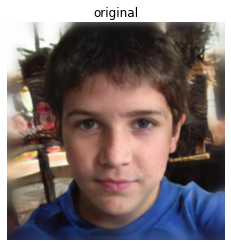

In [9]:
from PIL import Image

# Open and show the original (aligned) image.
img = Image.open('MyImage.jpg')
show(np.array(img), sz=4, title='original')

In [10]:
!python encode_image.py ./MyImage.jpg\
    pred_dlatents_myImage.npy\
    --use_latent_finder true\
    --image_to_latent_path ./trained_models/image_to_latent.pt

Optimizing Latents.
[2021-12-23 02:00:51,562][INFO] Loading pytorch model from `InterFaceGAN/models/pretrain/stylegan_ffhq.pth`.
[2021-12-23 02:00:51,790][INFO] Successfully loaded!
[2021-12-23 02:00:51,791][INFO]   `lod` of the loaded model is 0.0.
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100% 528M/528M [00:26<00:00, 21.2MB/s]
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100% 97.8M/97.8M [00:05<00:00, 19.9MB/s]
Step: 999, Loss: 2.57973051071167: 100% 1000/1000 [01:34<00:00, 10.59it/s]


Remember we aligned the image using the Puzer repo. Now we are encoding the image (basically extracting the latent vector that minimizes the difference between the aligned image and the image generated from the latent vector) from the jacobhallberg repo.

<br>

I'm curious. Let's investigate into this encode_image.py file.

```py
    for step in progress_bar:
        optimizer.zero_grad()

        generated_image_features = latent_optimizer(latents_to_be_optimized)
        
        loss = criterion(generated_image_features, reference_features)
        loss.backward()
        loss = loss.item()

        optimizer.step()
```

I glanced over the file and this part seems to be the most relevant. It simply finds a latent vector which minimizes a LatentLoss between the generated image from that latent vector and the aligned image!

Let's also take a look at the arguments to learn how to use this script!



```py
parser.add_argument("image_path", help="Filepath of the image to be encoded.")
parser.add_argument("dlatent_path", help="Filepath to save the dlatent (WP) at.")

parser.add_argument("--save_optimized_image", default=False, help="Whether or not to save the image created with the optimized latents.", type=bool)
parser.add_argument("--optimized_image_path", default="optimized.png", help="The path to save the image created with the optimized latents.", type=str)
parser.add_argument("--video", default=False, help="Whether or not to save a video of the encoding process.", type=bool)
parser.add_argument("--video_path", default="video.avi", help="Where to save the video at.", type=str)
parser.add_argument("--save_frequency", default=10, help="How often to save the images to video. Smaller = Faster.", type=int)
parser.add_argument("--iterations", default=1000, help="Number of optimizations steps.", type=int)
parser.add_argument("--model_type", default="stylegan_ffhq", help="The model to use from InterFaceGAN repo.", type=str)
parser.add_argument("--learning_rate", default=1, help="Learning rate for SGD.", type=int)
parser.add_argument("--vgg_layer", default=12, help="The VGG network layer number to extract features from.", type=int)
parser.add_argument("--use_latent_finder", default=False, help="Whether or not to use a latent finder to find the starting latents to optimize from.", type=bool)
parser.add_argument("--image_to_latent_path", default="image_to_latent.pt", help="The path to the .pt (Pytorch) latent finder model.", type=str)
```

The first 2 arguments are essential. They detail where the aligned image is and where to save the npy latent vector. The `--use_latent_finder` and `--image_to_latent_path` are jointly used. Given `--use_latent_finder` to be true, specify a path to the model that will find the starting latent vector to optimize from. I assume these 2 arguments aren't necessary. They are just used to optimize for time and speed (because we have to iteratively find a latent vector).




```py
# These have already been initialized, but I include them here for reference because we will use the
# latent2image function.

post_processing = PostSynthesisProcessing()
post_process = lambda image: post_processing(image).detach().cpu().numpy().astype(np.uint8)[0]

def latent2image(latent):
    img = post_process(synthesizer(latent))
    img = img.transpose(1,2,0)
    return img
```



In [11]:
# Load the npy latent vector.
pred_dlatents = np.load('pred_dlatents_myImage.npy')

# Load it into cuda with torch.
pred_dlatent = torch.from_numpy(pred_dlatents).float().cuda()

# Turn it into an image.
pred_image = latent2image(pred_dlatent)

Let's do a quick recap. We took our raw image, aligned it, then found the best latent vector to represent it. Now we are displaying the image generated by that best latent vector Great, so we found a vector to represent our aligned image. But what now? Well, we can step through the latent space and explore it by making additions to the latent vector. Then regenerating the image via the latent2image function. Traversing the latent space will open up possibilities of discontinuities or a failure in learning, but more importantly here, it will show how different points in the latent space transfigure the objects in the image!

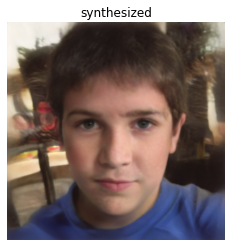

In [12]:
show(pred_image, sz=4, title='synthesized')  # Pretty solid!

In [13]:
idxs_to_swap = slice(0,3)
idxs_to_swap  # A python slice function to swap indices.

slice(0, 3, None)

In [14]:
# Load in that latent vector.
my_latents = torch.Tensor(np.load('pred_dlatents_myImage.npy', allow_pickle=True))

- What is the allow_pickle parameter?

> Allow loading pickled object arrays stored in npy files. Reasons for disallowing pickles include security, as loading pickled data can execute arbitrary code

In [15]:
my_latents.shape  
# shape: (A, B, C)
# A: num images.
# B: not sure...perhaps its another z_dim? Instead of a latent vector, it's a latent matrix.
# C: z_dim.

torch.Size([1, 18, 512])

In [16]:
# We are basically getting 2 images:
# A - a reconstructed aligned image from what we imported (MyImage.jpg).
# B - a generated image from the random latents we defined earlier.

# Here's a reference to rand_latents.

# rand_latents = torch.randn(1,512).cuda()

A, B = latent2image(my_latents.cuda()), latent2image(trunc(mapper(rand_latents)))

generated_image_latents = trunc(mapper(rand_latents))  # Get the generated latents from the output of the truncator.

# Swap the indices then convert the latent to an image for image A.
x = my_latents.clone()
x[:, idxs_to_swap] = generated_image_latents[:, idxs_to_swap]
a = latent2image(x.float().cuda())

# Swap the indices then convert the latent to an image for image B.
x = generated_image_latents.clone()
x[:, idxs_to_swap] = my_latents[:, idxs_to_swap]
b = latent2image(x.float().cuda())

In [17]:
# Checking the size of generated_image_latents.
print(generated_image_latents.shape)

torch.Size([1, 18, 512])


What is this idxs_to_swap doing?

Let's test this out.

In [18]:
test_tensor = torch.rand(1, 18, 512)
test_tensor[:, idxs_to_swap].shape  # Different values in this latent matrix are responsible for different things.
# It simply slices 3 rows from one matrix and sets them to the 3 specified rows in another matrix.

torch.Size([1, 3, 512])

That's cool! But, let's recap. 

`my_latent` is the latent vector that best matches our aligned raw image. `rand_latent` is a random *normal* latent vector. They are of different shapes. `my_latent` is of shape (1, 18, 512) whereas `rand_latent` is of shape (1, 512). Passing our `rand_latent` through the mapping and truncator functions, we get a new generated `rand_latent` that is of shape (1, 18, 512). Now that we have latent matrices for both our random latent vector and our given image, we can combine them. It should be noted that the `my_latent` latent matrix was generated directly from finding the best (1, 18, 512) matrix to represent our aligned input image. In contrast, our `rand_latent` was generated from a normal distribution, passed through a mapper and a truncator to finally arrive at that shape. So, in a way, finding `my_latent` would bypass the need to call `mapper` or `trunc`.

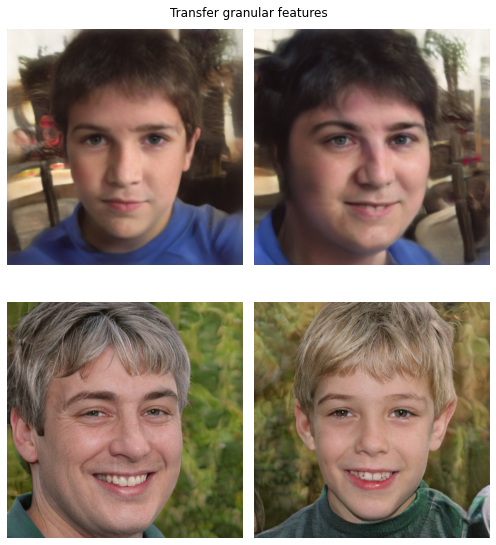

In [19]:
subplots([A,a,B,b], figsize=(7,8), nc=2, suptitle='Transfer granular features')  # I'm blown away...

In [20]:
!python InterFaceGAN/edit.py\
 -m stylegan_ffhq\
 -o results_new_smile\
 -b InterFaceGAN/boundaries/stylegan_ffhq_smile_w_boundary.npy\
 -i pred_dlatents_myImage.npy\
 -s WP\
 --steps 20

[2021-12-23 02:17:19,653][INFO] Initializing generator.
[2021-12-23 02:17:19,931][INFO] Loading pytorch model from `InterFaceGAN/models/pretrain/stylegan_ffhq.pth`.
[2021-12-23 02:17:20,151][INFO] Successfully loaded!
[2021-12-23 02:17:20,151][INFO]   `lod` of the loaded model is 0.0.
[2021-12-23 02:17:23,414][INFO] Preparing boundary.
[2021-12-23 02:17:23,416][INFO] Preparing latent codes.
[2021-12-23 02:17:23,416][INFO]   Load latent codes from `pred_dlatents_myImage.npy`.
[2021-12-23 02:17:23,417][INFO] Editing 1 samples.
[2021-12-23 02:17:25,022][INFO] Successfully edited 1 samples.


Like we do with all the other functions and scripts, let's take a look at this last one! The file itself is very dense. It seems that this script aims at changing the latent vector given with some direction. Direction here means: in what way should be change this latent vector?

Moreover, there is a note in the docstring:

```py
NOTE: If you want to use W or W+ space of StyleGAN, please do not randomly
sample the latent code, since neither W nor W+ space is subject to Gaussian
distribution. Instead, please use `generate_data.py` to get the latent vectors
from W or W+ space first, and then use `--input_latent_codes_path` option to
pass in the latent vectors.
```

Let's take a look at the parameters:

```py
  parser.add_argument('-m', '--model_name', type=str, required=True,
                      choices=list(MODEL_POOL),
                      help='Name of the model for generation. (required)')
  parser.add_argument('-o', '--output_dir', type=str, required=True,
                      help='Directory to save the output results. (required)')
  parser.add_argument('-b', '--boundary_path', type=str, required=True,
                      help='Path to the semantic boundary. (required)')
  parser.add_argument('-i', '--input_latent_codes_path', type=str, default='',
                      help='If specified, will load latent codes from given '
                           'path instead of randomly sampling. (optional)')
  parser.add_argument('-s', '--latent_space_type', type=str, default='z',
                      choices=['z', 'Z', 'w', 'W', 'wp', 'wP', 'Wp', 'WP'],
                      help='Latent space used in Style GAN. (default: `Z`)')
```

- Looks like `-m` is for the file that stores the model weights.
- `-o` is the directory to save the outputs.
- `-b` is the boundary which is simply a npy file that can be found in the InferFaceGAN/boundaries folder.
- `-i` is the input latent vector.
- `-s` is the type of latent space used in StyleGAN.

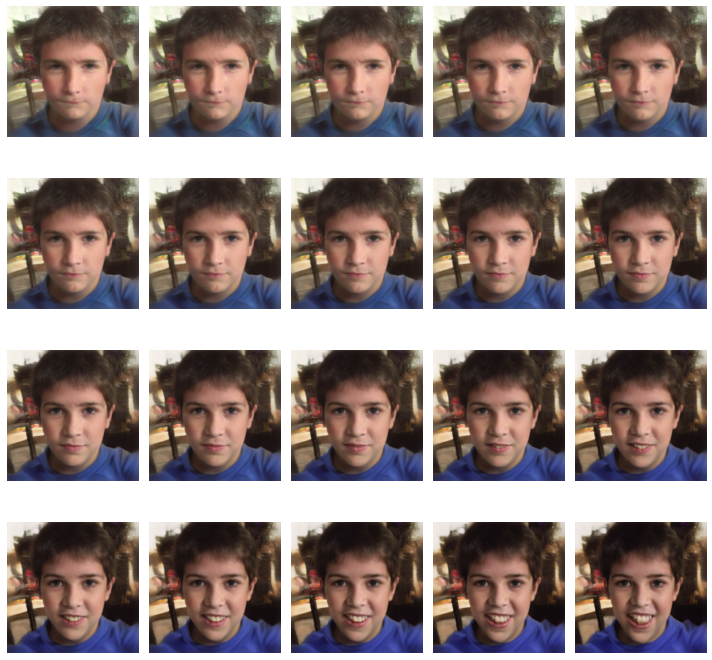

In [22]:
import glob
generated_faces = glob.glob('results_new_smile/*.jpg')
subplots([read(im,1) for im in sorted(generated_faces)],figsize=(10,10))  # Wow!